In [1]:
import pandas as pd
import numpy as np
import os
import sys

#!pip install librosa
#!pip install lifelines
#!pip install np_utils
#!pip install tensorflow
#!pip install -q -U keras-tuner

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

C:\Users\josha\AppData\Local\Temp\ipykernel_29892\589192907.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9470224431282739258
xla_global_id: -1
]


## Importing and Splitting the datasets

In [3]:
#importing the datasets (train_set_augmented for all landmarks, train_set_augmented_simplified for simplified landmarks)
train_set = pd.read_csv('outputs/train_set_augmented.csv')
test_set = pd.read_csv('outputs/test_set_augmented.csv')

In [4]:
#Split into features and target; x = features, y = target
x_train = train_set.iloc[:, 1:]
y_train = train_set['label']

x_test = test_set.iloc[:, 1:]
y_test = test_set['label']

In [5]:
x_test

lm_1_x    lm_1_y    lm_1_z    lm_2_x    lm_2_y    lm_2_z    lm_3_x  \
0     0.473046  0.696728 -0.091748  0.496471  0.604488 -0.168070  0.487032   
1     0.492350  0.714685 -0.045139  0.539254  0.634724 -0.090736  0.501687   
2     0.490669  0.726424 -0.042978  0.488736  0.653719 -0.136378  0.490637   
3     0.487772  0.715298 -0.064368  0.496388  0.642020 -0.135233  0.493557   
4     0.435017  0.681450 -0.019222  0.457655  0.626136 -0.113952  0.450812   
...        ...       ...       ...       ...       ...       ...       ...   
6174  0.467074  0.711874 -0.066803  0.490944  0.603252 -0.139190  0.483111   
6175  0.534954  0.675536 -0.061679  0.537082  0.602585 -0.165144  0.530123   
6176  0.526639  0.603841 -0.079819  0.522552  0.541407 -0.123911  0.524735   
6177  0.508241  0.732418 -0.038069  0.524389  0.678396 -0.128743  0.513136   
6178  0.500581  0.696320 -0.060420  0.481115  0.604108 -0.134518  0.492870   

        lm_3_y    lm_3_z    lm_4_x  ...  lm_475_z  lm_476_x  lm_476_y  \
0     0.632623 -0.092936  0.482524  ...  0.045890  0.670601  0.442534   
1     0.658425 -0.048153  0.519496  ...  0.064536  0.587501  0.457886   
2     0.671048 -0.063816  0.469890  ... -0.013364  0.624411  0.444959   
3     0.662816 -0.074048  0.482184  ...  0.018728  0.626525  0.459460   
4     0.634583 -0.041011  0.460500  ... -0.019818  0.633409  0.419269   
...        ...       ...       ...  ...       ...       ...       ...   
6174  0.631721 -0.069910  0.480523  ...  0.021422  0.644667  0.400973   
6175  0.622123 -0.084990  0.498073  ...  0.014990  0.644270  0.378498   
6176  0.568331 -0.071606  0.494399  ...  0.037879  0.624804  0.382451   
6177  0.690689 -0.060118  0.497018  ...  0.005707  0.614172  0.442669   
6178  0.628808 -0.066559  0.458894  ... -0.008156  0.650433  0.374878   

      lm_476_z  lm_477_x  lm_477_y  lm_477_z  lm_478_x  lm_478_y  lm_478_z  
0     0.045891  0.639195  0.458482  0.045855  0.660743  0.485365  0.045862  
1     0.064539  0.563775  0.476562  0.064510  0.579370  0.502035  0.064516  
2    -0.013364  0.599321  0.465061 -0.013393  0.623082  0.486691 -0.013390  
3     0.018728  0.600760  0.478731  0.018701  0.624030  0.500750  0.018706  
4    -0.019812  0.600469  0.436421 -0.019841  0.621377  0.467850 -0.019836  
...        ...       ...       ...       ...       ...       ...       ...  
6174  0.021424  0.611448  0.424229  0.021390  0.635391  0.457057  0.021397  
6175  0.014996  0.619339  0.399653  0.014956  0.647869  0.417729  0.014964  
6176  0.037881  0.603936  0.403715  0.037855  0.628075  0.421386  0.037861  
6177  0.005707  0.591247  0.464957  0.005678  0.614524  0.487100  0.005681  
6178 -0.008158  0.622625  0.399212 -0.008187  0.653293  0.421725 -0.008182  

[6179 rows x 1434 columns]

In [6]:
y_test

0         sad
1         sad
2       happy
3       happy
4       anger
        ...  
6174    anger
6175    anger
6176      sad
6177    happy
6178      sad
Name: label, Length: 6179, dtype: object

In [7]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

y_test

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28263, 1434, 1), (28263, 4), (6179, 1434, 1), (6179, 4))

## Hyperparameter Tuning



In [10]:
input_shape = (x_train.shape[1], 1)

In [11]:
def hypo_tuning_model(hp):
    model= Sequential()

    hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=256, step=32)
    hp_layer_3 = hp.Int('layer_3', min_value=32, max_value=128, step=32)
    hp_layer_4 = hp.Int('layer_4', min_value=32, max_value=64, step=32)
    hp_layer_dense = hp.Int('layer_dense', min_value=32, max_value=64, step=32)
    
    hp_layers_kernel = hp.Int('layer_kernel_size', min_value=1, max_value=7, step=2)
    hp_layers_strides = hp.Int('layer_strides', min_value=1, max_value=3, step=1)
    
    hp_layers_pool_size = hp.Int('max_pooling_pool_size', min_value=1, max_value=7, step=2)
    hp_layers_strides = hp.Int('max_pooling_strides', min_value=1, max_value=3, step=1)

    hp_layers_dropout = hp.Float('layer_dropout', min_value=0.05, max_value=0.3, step=0.05)
    hp_layers_dense_dropout = hp.Float('layer_dense_dropout', min_value=0.05, max_value=0.3, step=0.05)
    
    model.add(Conv1D(filters=hp_layer_1, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))

    model.add(Conv1D(filters=hp_layer_2, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))
    model.add(Dropout(hp_layers_dropout))
    
    model.add(Conv1D(filters=hp_layer_3, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))
    model.add(Dropout(hp_layers_dropout))
    
    model.add(Conv1D(filters=hp_layer_4, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units=hp_layer_dense, activation='relu'))
    model.add(Dense(units=hp_layer_dense, activation='relu'))
    model.add(Dense(units=hp_layer_dense, activation='relu'))
    model.add(Dropout(hp_layers_dense_dropout))
    
    model.add(Dense(units=4, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [12]:
import keras_tuner as kt

tuner = kt.Hyperband(hypo_tuning_model,
                     objective='val_accuracy',
                     max_epochs=11,
                     factor=3,
                     directory='dir',
                     project_name='full')

In [13]:
folder = 'full/ckpt_cnn'
checkpoint_filepath = os.getcwd() + '/' + folder + '/Epoch{epoch:02d}_{accuracy:.2f}.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max')

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)

In [14]:
tuner.search(x_train, y_train, batch_size=64, epochs=11, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback, early_stopping_callback, rlrp])

Trial 30 Complete [00h 07m 51s]
val_accuracy: 0.6748664975166321

Best val_accuracy So Far: 0.7549765110015869
Total elapsed time: 03h 14m 03s


In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

## Model Training

In [16]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 717, 384)          2304      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 359, 384)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 180, 128)          245888    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 90, 128)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 90, 128)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 45, 128)          

In [17]:
def train_model(model, folder, x_train, y_train, x_test, y_test):
    checkpoint_filepath = os.getcwd() + '/' + folder + '/Epoch{epoch:02d}_{accuracy:.2f}.keras'
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max')

    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)

    history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback, early_stopping_callback, rlrp])
    return history

In [18]:
history = train_model(model, folder,  x_train, y_train, x_test, y_test)

Epoch 1/50
442/442 [==============================] - 77s 170ms/step - loss: 0.9171 - accuracy: 0.6035 - val_loss: 0.7976 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 2/50
442/442 [==============================] - 74s 167ms/step - loss: 0.7969 - accuracy: 0.6666 - val_loss: 0.7360 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 3/50
442/442 [==============================] - 74s 167ms/step - loss: 0.7510 - accuracy: 0.6880 - val_loss: 0.6847 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 4/50
442/442 [==============================] - 74s 167ms/step - loss: 0.7156 - accuracy: 0.7092 - val_loss: 0.6732 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 5/50
442/442 [==============================] - 75s 169ms/step - loss: 0.6952 - accuracy: 0.7194 - val_loss: 0.6743 - val_accuracy: 0.7229 - lr: 0.0010
Epoch 6/50
442/442 [==============================] - 74s 168ms/step - loss: 0.6766 - accuracy: 0.7255 - val_loss: 0.6497 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 7/50
442/442 [==============================] 

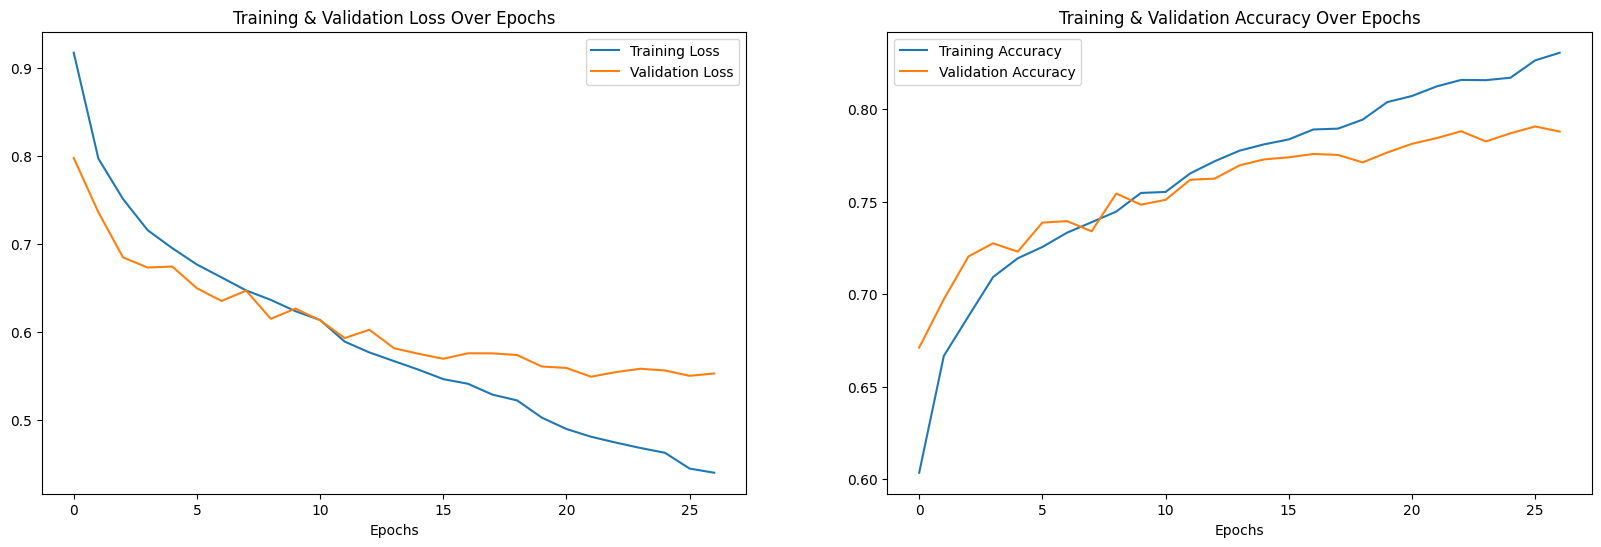

In [19]:
epochs = [i for i in range(len(history.history['accuracy']))]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [20]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

194/194 [==============================] - 5s 25ms/step


In [21]:
y_pred

array([['sad'],
       ['sad'],
       ['happy'],
       ...,
       ['sad'],
       ['happy'],
       ['sad']], dtype=object)

        anger happy neutral  sad
anger    1266    38     205  153
happy      22  1600      60   53
neutral   104    45    1084  163
sad       168    43     257  918


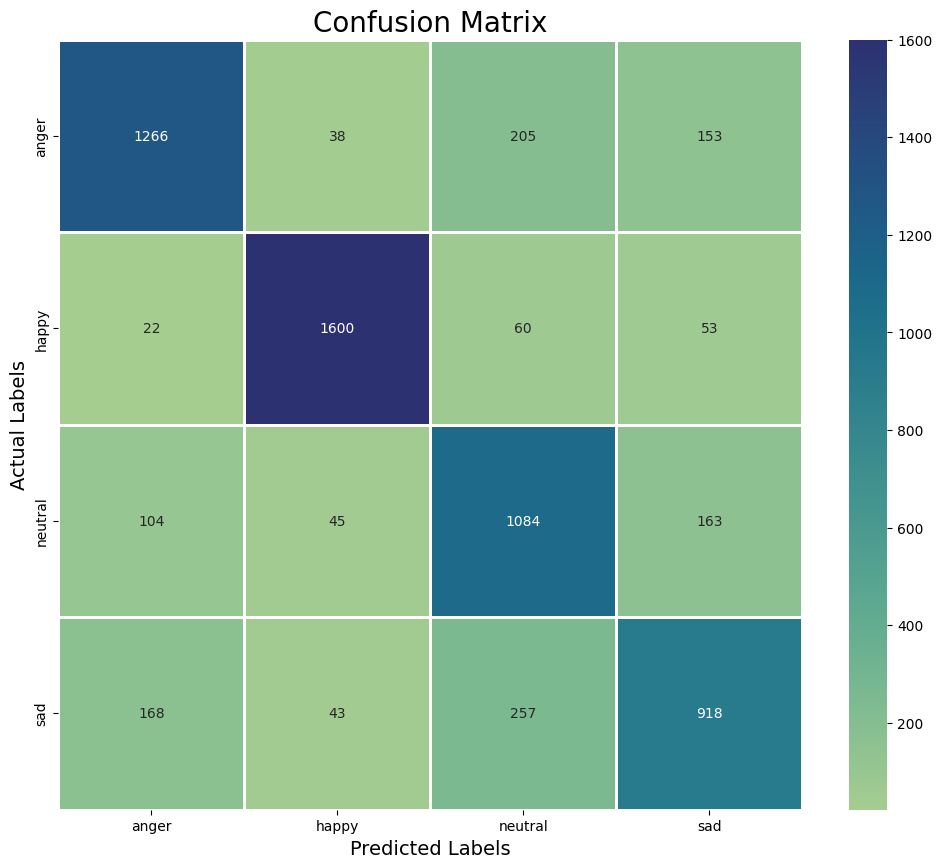

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='crest', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
print(cm)
plt.show()

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acs_test = accuracy_score(y_test,y_pred)
ps_test = precision_score(y_test,y_pred, average = "macro")
rs_test = recall_score(y_test,y_pred,  average = "macro")
fs_test = f1_score(y_test,y_pred,  average = "macro")

print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))

Accuracy Score:  78.78%
Precision Score:  78.17%
Recall Score:  78.07%
F1 Score:  77.99%


In [24]:
#K fold Cross Validation Module

#1. Get all rows together
all_data_df = pd.concat([train_set, test_set])
num_rows = len(all_data_df.index)

In [25]:
#2. Shuffle rows
all_data_df = all_data_df.sample(frac=1).reset_index()
all_data_df = all_data_df.drop(columns=['index'])    

In [26]:
#K fold cross validation for k=5 (5 runs)
fold_num_rows = num_rows // 5
last_fold_num_rows = num_rows - (fold_num_rows * 4)

confusion_matrices = []
scores = []
for i in range(0, 5):
    #Get number of rows to retrieve
    start = i * fold_num_rows
    end = (i + 1) * fold_num_rows
    if i == 4:
        end = num_rows

    print("K =", str(i+1), "getting images from", str(start), "to", str(end))
    
    #Construct train and test split using iloc
    test_df = all_data_df.iloc[start:end, : ]
    train_df = pd.concat([all_data_df, test_df]).drop_duplicates(keep=False)

    x_train = train_df.iloc[:, 1:]
    y_train = train_df['label']
    
    x_test = test_df.iloc[:, 1:]
    y_test = test_df['label']

    encoder = OneHotEncoder()
    y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
    y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)

    #Train the model
    model = tuner.hypermodel.build(best_hps)
    history = train_model(model, 'full/ckpt_cnn_k' + str(i+1), x_train, y_train, x_test, y_test)

    #Evaluate the model
    pred_test = model.predict(x_test)
    y_pred = encoder.inverse_transform(pred_test)
    y_test = encoder.inverse_transform(y_test)

    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
    
    acs_test = accuracy_score(y_test,y_pred)
    ps_test = precision_score(y_test,y_pred, average = "macro")
    rs_test = recall_score(y_test,y_pred,  average = "macro")
    fs_test = f1_score(y_test,y_pred,  average = "macro")

    fold_score = {
        "accuracy": acs_test,
        "precision": ps_test,
        "recall": rs_test,
        "f1": fs_test
    }

    #Save the scores
    confusion_matrices.append(cm)
    scores.append(fold_score)

K = 1 getting images from 0 to 6888
Epoch 1/50
396/396 [==============================] - 73s 180ms/step - loss: 0.9181 - accuracy: 0.6003 - val_loss: 0.8100 - val_accuracy: 0.6587 - lr: 0.0010
Epoch 2/50
396/396 [==============================] - 71s 180ms/step - loss: 0.7907 - accuracy: 0.6654 - val_loss: 0.7460 - val_accuracy: 0.6941 - lr: 0.0010
Epoch 3/50
396/396 [==============================] - 78s 198ms/step - loss: 0.7445 - accuracy: 0.6941 - val_loss: 0.7141 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 4/50
396/396 [==============================] - 72s 182ms/step - loss: 0.7115 - accuracy: 0.7092 - val_loss: 0.7052 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 5/50
396/396 [==============================] - 73s 185ms/step - loss: 0.6915 - accuracy: 0.7206 - val_loss: 0.6765 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 6/50
396/396 [==============================] - 71s 179ms/step - loss: 0.6720 - accuracy: 0.7276 - val_loss: 0.6696 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 7/50
396/3

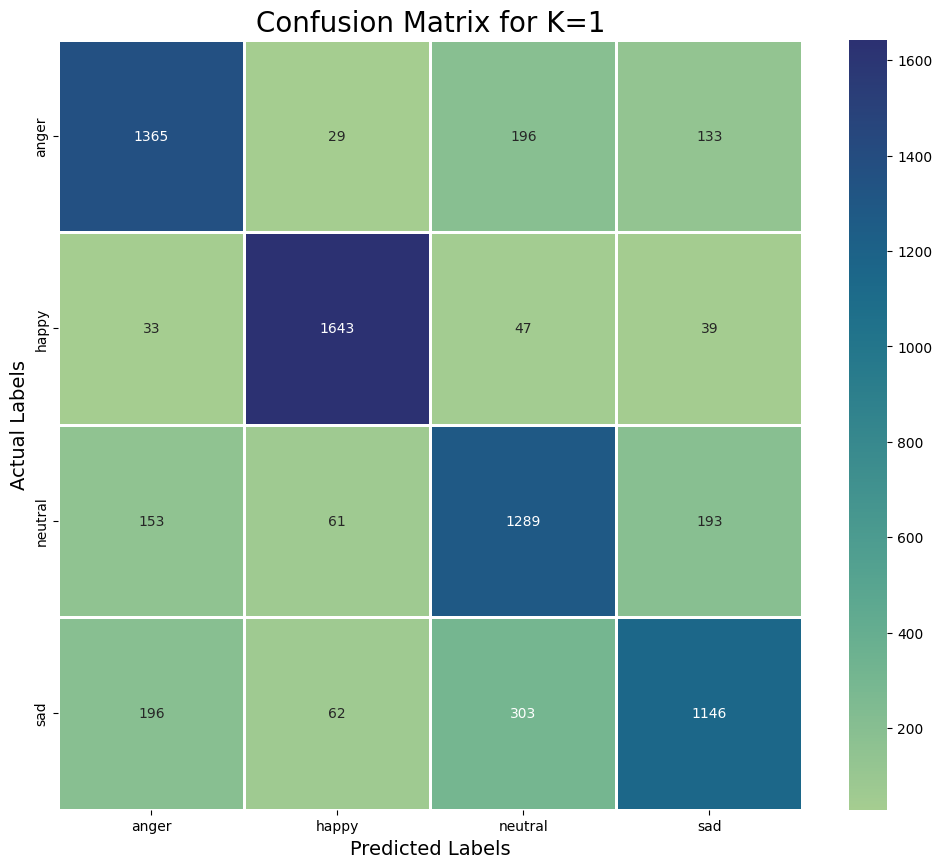

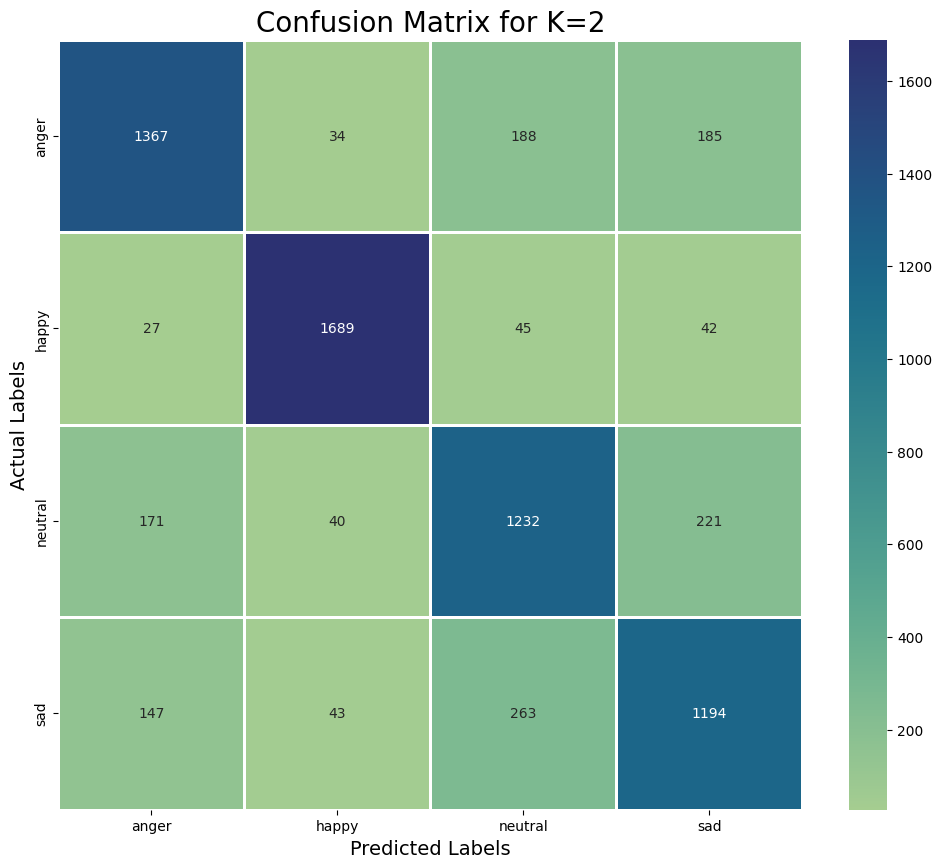

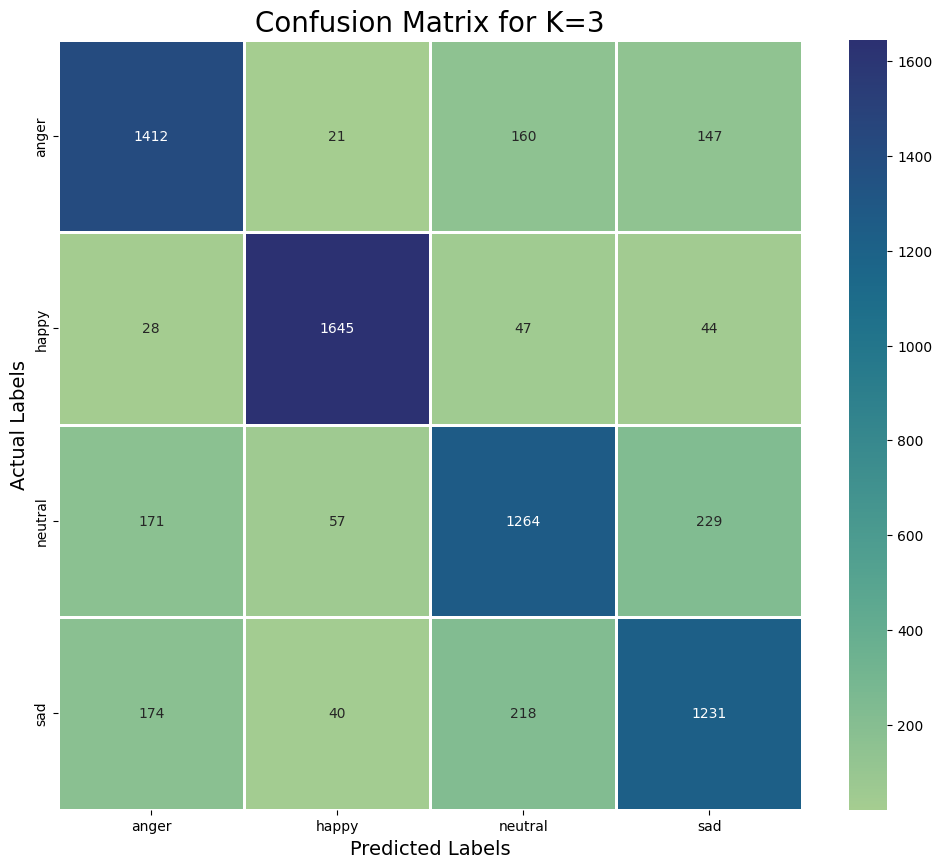

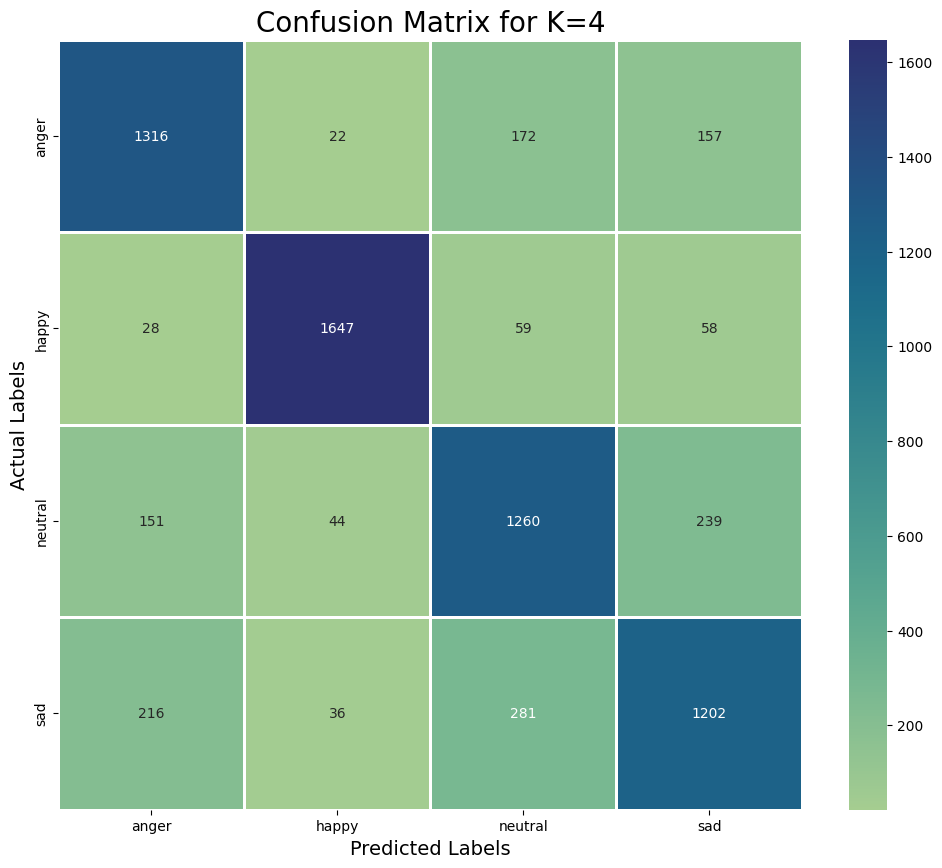

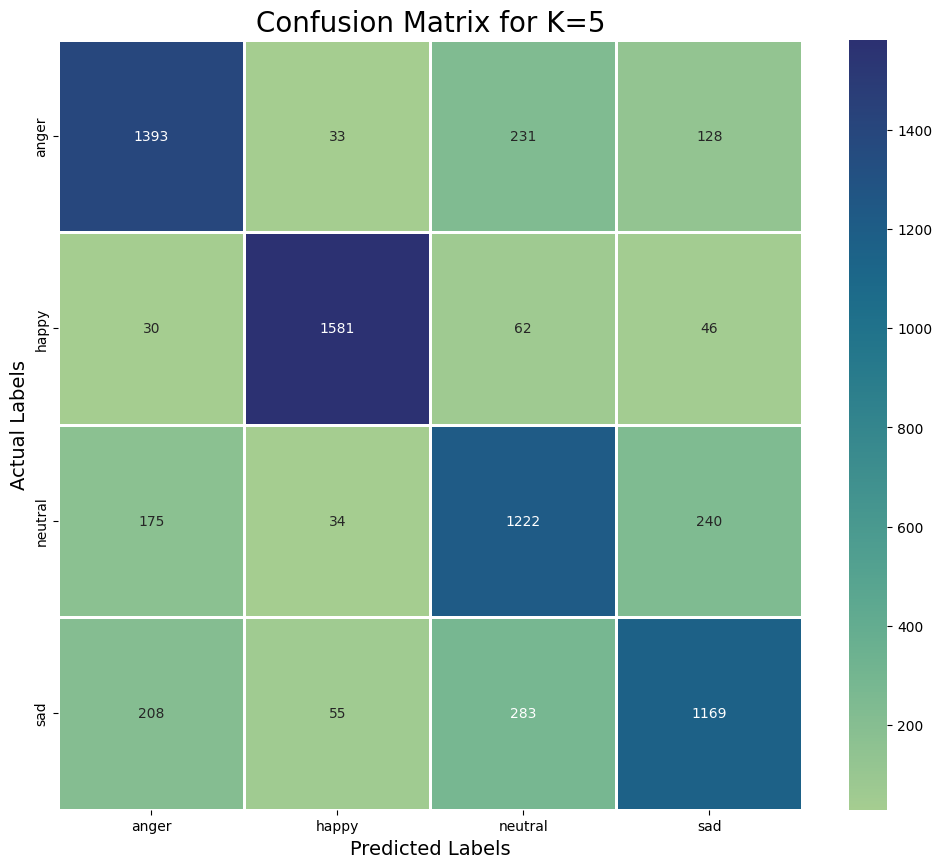

In [27]:
#Show each result in confusion matrix
for i in range(len(confusion_matrices)):
    cm = confusion_matrices[i]
    plt.figure(figsize = (12, 10))
    sns.heatmap(cm, linecolor='white', cmap='crest', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix for K='+str(i+1), size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)

In [28]:
#Show each score and summarize results

cross_val_score = {
    "accuracy": 0,
    "precision": 0,
    "recall": 0,
    "f1": 0
}
for i in range(len(scores)):
    acs_test = scores[i]['accuracy']
    ps_test = scores[i]['precision']
    rs_test = scores[i]['recall']
    fs_test = scores[i]['f1']
    
    print("Score Summary for K =",str(i+1))
    print("Accuracy Score: ", "{:.2%}".format(acs_test))
    print("Precision Score: ", "{:.2%}".format(ps_test))
    print("Recall Score: ", "{:.2%}".format(rs_test))
    print("F1 Score: ", "{:.2%}".format(fs_test))

    cross_val_score['accuracy'] += acs_test
    cross_val_score['precision'] += ps_test
    cross_val_score['recall'] += rs_test
    cross_val_score['f1'] += fs_test

cross_val_score['accuracy'] /= 5
cross_val_score['precision'] /= 5
cross_val_score['recall'] /= 5
cross_val_score['f1'] /= 5

Score Summary for K = 1
Accuracy Score:  79.02%
Precision Score:  78.94%
Recall Score:  78.90%
F1 Score:  78.82%
Score Summary for K = 2
Accuracy Score:  79.59%
Precision Score:  79.35%
Recall Score:  79.32%
F1 Score:  79.32%
Score Summary for K = 3
Accuracy Score:  80.60%
Precision Score:  80.45%
Recall Score:  80.47%
F1 Score:  80.45%
Score Summary for K = 4
Accuracy Score:  78.76%
Precision Score:  78.69%
Recall Score:  78.63%
F1 Score:  78.64%
Score Summary for K = 5
Accuracy Score:  77.87%
Precision Score:  77.94%
Recall Score:  77.83%
F1 Score:  77.83%


In [29]:
acs_test = cross_val_score['accuracy']
ps_test = cross_val_score['precision']
rs_test = cross_val_score['recall']
fs_test = cross_val_score['f1']

print("5-Fold Cross Validation Score Summary")
print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))


5-Fold Cross Validation Score Summary
Accuracy Score:  79.17%
Precision Score:  79.07%
Recall Score:  79.03%
F1 Score:  79.01%
